In [1]:
import numpy as np 
import pandas as pd 
import h5py
def load_h5(h5_path):
    # load training data
    with h5py.File(h5_path, 'r') as hf:
        print('List of arrays in input file:', list(hf.keys()))
        audio_name = np.array(hf.get('audio_name'))
        fold = np.array(hf.get('fold'))
        target = np.array(hf.get('target'))
        waveform = np.array(hf.get('waveform'))[0]
        print('Shape of audio_name:', audio_name.shape)
        print('Shape of fold:', fold.shape)
        print('Shape of target:', target.shape)
        print('Shape of waveform:', waveform.shape)
    return audio_name, fold, target, waveform

In [ ]:
audio_name, fold, target, waveform = load_h5('E:/data/minidata_waveform.h5')
import soundfile as sf
sf.write('example.wav', waveform, 16000)

List of arrays in input file: ['audio_name', 'fold', 'target', 'waveform']


In [1]:
import librosa
import torch
audio_path = './example.wav'
(waveform, _) = librosa.core.load(audio_path, sr=16000, mono=True)
input_tensor = torch.from_numpy(waveform).unsqueeze(0) # 预处理
input_tensor.shape

torch.Size([1, 480000])

In [2]:
from torchlibrosa.augmentation import SpecAugmentation
spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
                    freq_drop_width=16, freq_stripes_num=2)

In [3]:
from nnAudio import features
mel_bins = 64
fmin = 0
fmax = None
window_size = 1024
hop_size = 320
window = 'hann'
pad_mode = 'reflect'
center = True
device = 'cuda'
ref = 1.0
amin = 1e-10
top_db = None
spec_layer = features.stft.STFT(sr=16000, n_fft=window_size, win_length=window_size, fmin=fmin, fmax=fmax,
                                    hop_length=hop_size, window=window, center=center, pad_mode=pad_mode,
                               output_format='Magnitude')

STFT kernels created, time used = 0.0349 seconds


In [4]:
import numpy as np
def power_to_db(input):
    r"""Power to db, this function is the pytorch implementation of 
    librosa.power_to_lb
    """
    ref_value = 1.0
    amin = 1e-10
    top_db = 80.0

    log_spec = 10.0 * torch.log10(torch.clamp(input, min=amin, max=np.inf))
    log_spec -= 10.0 * np.log10(np.maximum(amin, ref_value))

    if top_db is not None:
        if top_db < 0:
            raise librosa.util.exceptions.ParameterError('top_db must be non-negative')
        log_spec = torch.clamp(log_spec, min=log_spec.max().item() - top_db, max=np.inf)

    return log_spec

In [15]:
x1 = spec_layer(input_tensor)

In [16]:
x2 = power_to_db(x1)

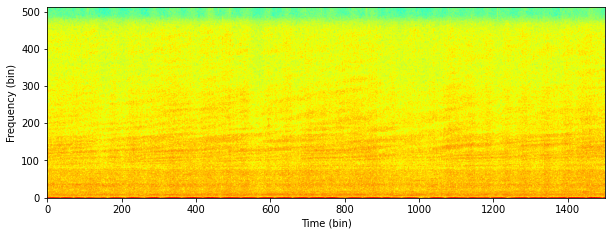

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(x2.squeeze(),origin='lower',cmap='jet')
plt.ylabel('Frequency (bin)')
plt.xlabel('Time (bin)')
plt.show()

In [8]:
x3 = x2.unsqueeze(3)
x3 = x3.transpose(1, 3)
x3.shape

torch.Size([1, 1, 1501, 513])

In [9]:
x3 = spec_augmenter(x3)

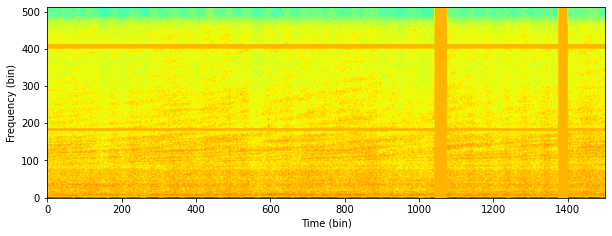

In [14]:
x3 = x3.transpose(1, 3)
plt.figure(figsize=(10, 10))
ax = plt.gca()  
ax.invert_yaxis()
plt.imshow(x3.squeeze(),origin='lower',cmap='jet')
plt.ylabel('Frequency (bin)')
plt.xlabel('Time (bin)')
plt.show()